In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

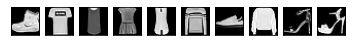

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

n = 10
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [3]:
print(x_train.shape[0])
print(x_train[0].shape)
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print(x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5

60000
(28, 28)
784


In [4]:

optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [5]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [6]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model  

In [7]:
use_discriminator = build_discriminator()
use_generator = build_generator()

use_discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = use_generator(gan_input)
gan_output = use_discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [8]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'copper')
        plt.axis('off')
        plt.tight_layout()
    plt.show()
    
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
            
            generated_images = use_generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  
            use_discriminator.trainable = True
            d_loss = use_discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            use_discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, use_generator)

epoch:  0


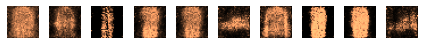

epoch:  20


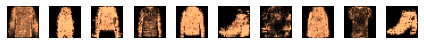

epoch:  40


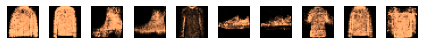

epoch:  60


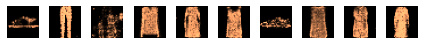

epoch:  80


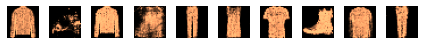

epoch:  100


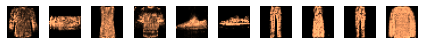

In [9]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

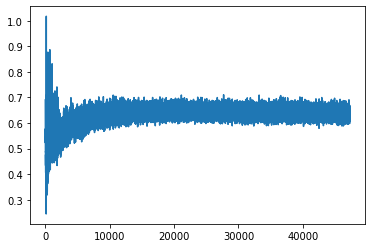

In [10]:
plt.plot(discrim_losses)